In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm import tqdm
from collections import OrderedDict

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    
    with tqdm(train_loader) as _tqdm:
    
        for data, target in _tqdm:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            
            _tqdm.set_postfix(OrderedDict(step=epoch, loss=loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        with tqdm(test_loader) as _tqdm:
            
            for data, target in _tqdm:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
                test_loss += loss
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                _tqdm.set_postfix(OrderedDict(step=epoch, loss=loss))

    test_loss /= len(test_loader.dataset)
    print('test_loss: {:.4f}, test_acc: {:.4f}'.format(
        test_loss, correct / len(test_loader.dataset)))

batch_size = 64
lr = 0.01
momentum = 0.5
epochs = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

100%|██████████| 157/157 [00:00<00:00, 201.46it/s, step=1, loss=1.43]

test_loss: 0.2223, test_acc: 0.9311


In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

n = 0
for x in train_loader:
    print(len(x), x[0].shape)
    break

2 torch.Size([64, 1, 28, 28])


60000
torch.Size([1, 28, 28]) tensor(5)


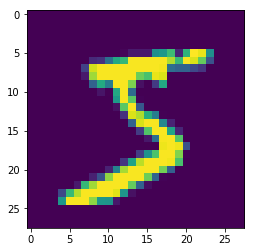

In [15]:
data = datasets.MNIST('../mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

print(len(data))
print(data[0][0].shape, data[0][1])
import matplotlib.pyplot as plt
plt.imshow(data[0][0][0]); plt.show()